### Project - Predicting Insurance Costs based on Demographic Factors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


from scipy.stats import boxcox

In [2]:
insurance = pd.read_csv('insurance.csv')


In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
insurance['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [6]:
insurance.corr()['charges']

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

### Variable Selection - Correlation Analysis (Continuous variables)

In [7]:
insurance.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


### Variable Selection - Correlation Analysis (Categorical variables)

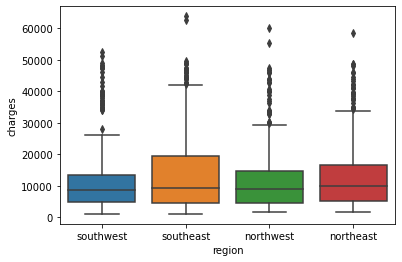

In [8]:
import seaborn as sns

sns.boxplot(data = insurance, x = 'region', y = 'charges' )
plt.show()

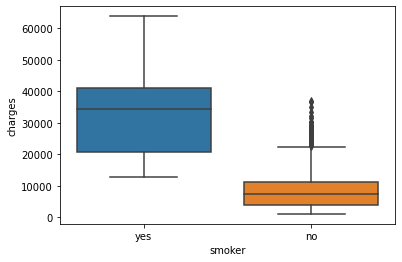

In [9]:
import seaborn as sns

sns.boxplot(data = insurance, x = 'smoker', y = 'charges' )
plt.show()

#### Thus we can observe that smokers have higher charges/insurance costs and the continuous variables 'age' and 'bmi' have a high correlation (approx 30% and 20% respectively) with the outcome variable - 'charges' (which indicates insurance costs). Hence we will select these variables. 

### Analyzing the Outcome variable 'charges'

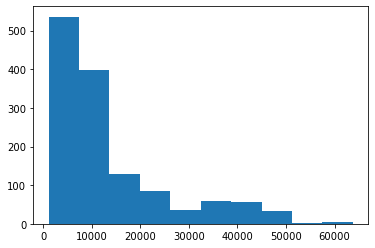

In [10]:
plt.hist(insurance['charges'])
plt.show()

#### It can be observed that the charges are heavily skewed towards the right. It would be better to transform the variable. We will check both the log as well as boxcox transformations. 

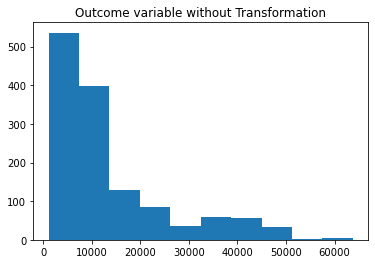

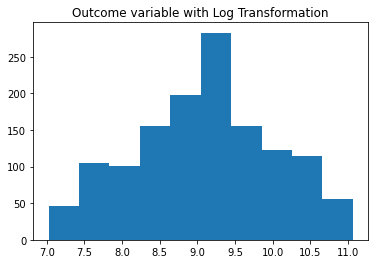

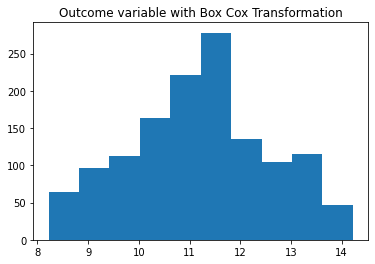

In [11]:
insurance['log_normal_charges'] = boxcox(insurance['charges'],lmbda = 0)
insurance['boxcox_charges'] = boxcox(insurance['charges'])[0]

plt.hist(insurance['charges'])
plt.title('Outcome variable without Transformation')
plt.show()


plt.hist(insurance['log_normal_charges'])
plt.title('Outcome variable with Log Transformation')
plt.show()


plt.hist(insurance['boxcox_charges'])
plt.title('Outcome variable with Box Cox Transformation')
plt.show()




#### The Log Transformation is more centered, hence we will select that over the BoxCox Transformation.

### Thus, the variables selected are age, bmi and 'smoker' and the outcome variable's Log Transformation will be selected for Regression Analysis. 

### Dividing into Training and Test Data (Ratio of 80-20)

In [12]:
X = insurance[['age', 'bmi', 'smoker']]

X = pd.get_dummies(data = X, columns = ['smoker'], drop_first = True)

Y = insurance['log_normal_charges']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 730)

In [13]:
X.head()

# Alternate way of ensuring that we get smokers = yes in the coded column 

#insurance["is_smoker"] = (insurance["smoker"] == "yes") #True would be considered as 1 in the regression

,age,bmi,smoker_yes
0,19,27.900,1
1,18,33.770,0
2,28,33.000,0
3,33,22.705,0
4,32,28.880,0


In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
model.coef_

array([0.03565777, 0.01137433, 1.54448252])

In [16]:
y_pred = model.predict(X_train)
R2 = r2_score(y_train,y_pred)
print('The R square value is', R2)

The R square value is 0.7513666641041514


In [17]:
mse = np.exp(mean_squared_error(y_train,y_pred))

In [18]:
print('The MSE is', mse)

The MSE is 1.233646855184268


#### The R2 value is 75.13% which means that the model explains about 75% of the variation.The Training MSE is 1.23. These indicate a good fit. But these should be considered optimistic values as they have been evaluated on the Training Set. 

### Residual Diagnostics (Checking for Model Assumptions)

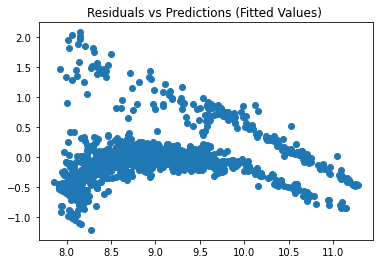

In [19]:
predictions = y_pred
y_actuals = y_train


residuals = y_actuals - predictions

plt.scatter(predictions, residuals)
plt.title('Residuals vs Predictions (Fitted Values) ')
plt.show()

#### Observations - 
1. The residuals are not centered around the mean. (Assumption violated : Mean(Errors) = 0)
2. The residuals are sloping downwards. (Assumption violated : Linear Relationship between the variables and the outcome).
3. They do not have a constant band / variation. (Assumption violated : Constancy of variance of Error Terms). 

These do not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

###  Interpreting The Model

In [20]:
intercept = model.intercept_

In [21]:
print(intercept)

7.032730008429479


#### The intercept value is 7.03. Since the age or BMI of a person cannot be zero, the intercept here is not meaningful. 

In [22]:
print(model.coef_)
#The sequence is Áge, BMI, Smoker_yes

[0.03565777 0.01137433 1.54448252]


#### The coefficients are on a log scale, and should be tranformed back to the original scale. 

In [23]:
model_coef_regular_scale = np.exp(model.coef_)
print(model_coef_regular_scale)

[1.03630114 1.01143926 4.68554634]


#### Interpretation of Coefficients - 

1. For the increase of every 1 year in age, the cost increases by 3.6 % keeping the other factors (BMI and Smoker_yes) constant.
2. For the increase of every 1 point on the MBI index, 1.14% keeping the other factors (Age and Smoker_yes) constant.
3. If a person is a smoker, the cost goes up by 468.5%.  

### Final Model Evaluation (Test Set)

In [24]:
predictions_test = model.predict(X_test)

mse_test = mean_squared_error(y_test, predictions_test)
mse_train = mean_squared_error(y_train, predictions)

mse_test = np.exp(mse_test)
mse_train = np.exp(mse_train)


print('The Training MSE is ', mse_train)
print('The Test MSE is ', mse_test)


The Training MSE is  1.233646855184268
The Test MSE is  1.2705289186786557


### Conclusion

#### The test MSE was about 1.27, while the training MSE was about 1.23. In this case, the two errors are close, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

#### We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.